In [1]:
%%javascript
utils.load_extension("collapsible_headings/main")
utils.load_extension("hide_input/main")
utils.load_extension("autosavetime/main")
utils.load_extension("execute_time/ExecuteTime")
utils.load_extension("code_prettify/code_prettify")
utils.load_extension("scroll_down/main")
utils.load_extension("jupyter-js-widgets/extension")

<IPython.core.display.Javascript object>

In [2]:
from sklearn import *
import sklearn
import time
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("max_columns", None)
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from scipy.stats import wilcoxon
import pdb


from sklearn.feature_selection import VarianceThreshold
import zipfile
import os

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from tqdm.notebook import tqdm

import random

random.seed(0)

from pmlb import fetch_data, regression_dataset_names
from tqdm import tqdm
import time

from category_encoders.target_encoder import TargetEncoder
from category_encoders.m_estimate import MEstimateEncoder

import warnings

warnings.filterwarnings("ignore")

import sktools
from tabulate import tabulate

/Users/cmougan/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
class TypeSelector(BaseEstimator, TransformerMixin):
    """
    Transformer that filters a type of columns of a given data frame.
    """

    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        # print("Type Selector out shape {}".format(X.select_dtypes(include=[self.dtype]).shape))
        # print(X.select_dtypes(include=[self.dtype]).dtypes)
        return X.select_dtypes(include=[self.dtype])


In [4]:
df = pd.read_csv('data/stackoverflow.csv')

In [5]:
df = df.sample(frac=0.1)

In [6]:
df = df[["Country", "Employment", "FormalEducation", "DevType", "LanguageWorkedWith",'ConvertedSalary']]
df = df[["Country", "Employment", "FormalEducation",  "LanguageWorkedWith",'ConvertedSalary']]

In [7]:
cols_enc = ["Country", "Employment", "FormalEducation", "DevType", "LanguageWorkedWith"]
cols_enc = ["Country", "Employment", "FormalEducation", "LanguageWorkedWith"]

In [8]:
def f(m, q):
    out = np.zeros([len(m), len(q)])

    for i in tqdm(range(0, len(m)), desc=" outer", position=0):
        for j in tqdm(range(0,len(q)), desc=" inner", position=1,leave=False):
            # Elastic Net + percentile encoding
            scaler = sklearn.preprocessing.StandardScaler()
            clf = sklearn.linear_model.ElasticNet()
            pe = sktools.QuantileEncoder(cols=cols_enc, quantile=0.50, m=0)

            pipe = Pipeline([
                ("pe", pe),
                ("selector",
                 TypeSelector(np.number)),  # Selects Numerical Columns only
                ("scaler", scaler),
                ("clf", clf),
            ])

            pipe_grid = {
                "pe__m": [m[i]],
                "pe__quantile": [q[j]],
            }

            pipe_cv = GridSearchCV(
                pipe,
                param_grid=pipe_grid,
                n_jobs=-1,
                cv=3,
                scoring="neg_mean_absolute_error",
            )

            pipe_cv.fit(df.drop(columns='ConvertedSalary'), df.ConvertedSalary)

            out[i][j] = pipe_cv.cv_results_['mean_test_score']

    return out

In [9]:
M = [0,1,2,3,4,5]
Q = np.linspace(0, 1, 6)
Z = f(M, Q)
M, Q = np.meshgrid(M, Q)

 outer: 100%|██████████| 6/6 [00:40<00:00,  6.67s/it]


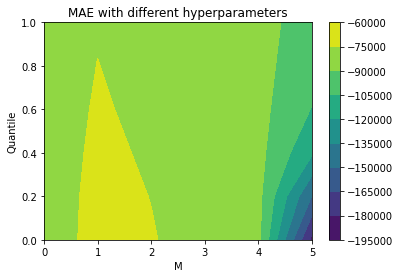

In [10]:
plt.plot()
cp = plt.contourf(M, Q, Z)
plt.colorbar(cp)  #Add a colorbar to a plot
plt.xlabel('M')
plt.ylabel('Quantile')
plt.title('MAE with different hyperparameters')
plt.savefig('hyperparameters_contour.eps',format='eps')
plt.show()